This notebook is based on the file [Logistic Regression programming exercise](https://colab.research.google.com/notebooks/mlcc/logistic_regression.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=logisticregression-colab&hl=en), which is part of Google's [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/).

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Logistic Regression

**Learning Objectives:**
  * Reframe the median house value predictor (from the preceding exercises) as a binary classification model
  * Compare the effectiveness of logisitic regression vs linear regression for a binary classification problem

As in the prior exercises, we're working with the [California housing data set](https://developers.google.com/machine-learning/crash-course/california-housing-data-description), but this time we will turn it into a binary classification problem by predicting whether a city block is a high-cost city block. We'll also revert to the default features, for now.

## Frame the Problem as Binary Classification

The target of our dataset is `median_house_value` which is a numeric (continuous-valued) feature. We can create a boolean label by applying a threshold to this continuous value.

Given features describing a city block, we wish to predict if it is a high-cost city block. To prepare the targets for train and eval data, we define a classification threshold of the 75%-ile for median house value (a value of approximately 265000). All house values above the threshold are labeled `1`, and all others are labeled `0`.

## Setup

Run the cells below to load the data and prepare the input features and targets.

In [1]:
using Plots
using Distributions
gr()
using DataFrames
using TensorFlow
import CSV
import StatsBase
using PyCall

sess=Session(Graph())
california_housing_dataframe = CSV.read("california_housing_train.csv", delim=",");
california_housing_dataframe = california_housing_dataframe[shuffle(1:size(california_housing_dataframe, 1)),:];

Note how the code below is slightly different from the previous exercises. Instead of using `median_house_value` as target, we create a new binary target, `median_house_value_is_high`.

In [2]:
function preprocess_features(california_housing_dataframe)
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    [:latitude,
     :longitude,
     :housing_median_age,
     :total_rooms,
     :total_bedrooms,
     :population,
     :households,
     :median_income]]
  processed_features = selected_features
  # Create a synthetic feature.
  processed_features[:rooms_per_person] = (
    california_housing_dataframe[:total_rooms] ./
    california_housing_dataframe[:population])
  return processed_features
end
    

function preprocess_targets(california_housing_dataframe)
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets[:median_house_value_is_high] = convert.(Float64,
    california_housing_dataframe[:median_house_value] .> 265000)
  return output_targets
end


preprocess_targets (generic function with 1 method)

2018-08-22 21:28:53.563570: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.2 AVX AVX2 FMA


In [3]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(head(california_housing_dataframe,12000))
training_targets = preprocess_targets(head(california_housing_dataframe,12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(tail(california_housing_dataframe,5000))
validation_targets = preprocess_targets(tail(california_housing_dataframe,5000))

# Double-check that we've done the right thing.
println("Training examples summary:")
describe(training_examples)
println("Validation examples summary:")
describe(validation_examples)

println("Training targets summary:")
describe(training_targets)
println("Validation targets summary:")
describe(validation_targets)

Training examples summary:


,variable,mean,min,median,max,nunique,nmissing,eltype
1,median_house_value_is_high,0.2514,0.0,0.0,1.0,,,Float64


## How Would Linear Regression Fare?
To see why logistic regression is effective, let us first train a naive model that uses linear regression. This model will use labels with values in the set `{0, 1}` and will try to predict a continuous value that is as close as possible to `0` or `1`. Furthermore, we wish to interpret the output as a probability, so it would be ideal if the output will be within the range `(0, 1)`. We would then apply a threshold of `0.5` to determine the label.

Run the cells below to train the linear regression model.

In [4]:
function construct_feature_columns(input_features)
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  out=convert(Array, input_features[:,:])
  return convert.(Float64,out)
end    

construct_feature_columns (generic function with 1 method)

Validation examples summary:
Training targets summary:
Validation targets summary:


In [5]:
function create_batches(features, targets, steps, batch_size=5, num_epochs=0)
  """Create batches.

  Args:
    features: Input features.
    targets: Target column.
    steps: Number of steps.
    batch_size: Batch size.
    num_epochs: Number of epochs, 0 will let TF automatically calculate the correct number
  Returns:
    An extended set of feature and target columns from which batches can be extracted.
  """  
    
    if(num_epochs==0)
        num_epochs=ceil(batch_size*steps/size(features,1))
    end
    
    names_features=names(features);
    names_targets=names(targets);
    
    features_batches=copy(features)
    target_batches=copy(targets)
    
    for i=1:num_epochs    
        select=shuffle(1:size(features,1)) 
        if i==1
            features_batches=(features[select,:])
            target_batches=(targets[select,:])
        else     
            append!(features_batches, features[select,:])
            append!(target_batches, targets[select,:])
        end
    end 
    return features_batches, target_batches 
end

create_batches (generic function with 3 methods)

In [6]:
function next_batch(features_batches, targets_batches, batch_size, iter)
  """Next batch.

  Args:
    features_batches: Features batches from create_batches.
    targets_batches: Target batches from create_batches.
    batch_size: Batch size.
    iter: Number of the current iteration
  Returns:
    An extended set of feature and target columns from which batches can be extracted.
  """  
    select=mod((iter-1)*batch_size+1, size(features_batches,1)):mod(iter*batch_size, size(features_batches,1));

    ds=features_batches[select,:];
    target=targets_batches[select,:];
    
    return ds, target
end

next_batch (generic function with 1 method)

In [7]:
function my_input_fn(features_batches, targets_batches, iter, batch_size=5, shuffle_flag=1):
    """Prepares a batch of features and labels for model training.
  
    Args:
      features: DataFrame of features
      targets: DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """         
    # Construct a dataset, and configure batching/repeating.
    ds, target = next_batch(features_batches, targets_batches, batch_size, iter)
    
    # Shuffle the data, if specified.
    if shuffle_flag==1
      select=shuffle(1:size(ds, 1));
        ds = ds[select,:]
        target = target[select, :]
    end
    
    # Return the next batch of data.
    return ds, target
end

my_input_fn (generic function with 3 methods)

In [8]:
function train_linear_regressor_model(learning_rate,
                     steps, 
                     batch_size, 
                     training_examples, 
                     training_targets, 
                     validation_examples, 
                     validation_targets)
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples:
    training_targets: 
    validation_examples: 
    validation_targets:
  Returns:
    weight: The weights of the model.
    bias: Bias of the model.
    p1: Graph containing the loss function values for the different iterations.
  """
  
  periods = 10
  steps_per_period = steps / periods

  # Create feature columns.
  feature_columns = placeholder(Float32)
  target_columns = placeholder(Float32)
  
  # Create a linear regressor object.
  m=Variable(zeros(length(training_examples),1))
  b=Variable(0.0)
  y=(feature_columns*m) .+ b
  loss=reduce_sum((target_columns - y).^2)
  
  features_batches, targets_batches = create_batches(training_examples, training_targets, steps, batch_size)
    
  # Use gradient descent as the optimizer for training the model.
  # Advanced gradient decent with gradient clipping
    my_optimizer=(train.GradientDescentOptimizer(learning_rate))
    gvs = train.compute_gradients(my_optimizer, loss)
    capped_gvs = [(clip_by_norm(grad, 5.), var) for (grad, var) in gvs]
    my_optimizer = train.apply_gradients(my_optimizer,capped_gvs) 
    run(sess, global_variables_initializer())
    
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  println("Training model...")
  println("RMSE (on training data):")
  training_rmse = []
  validation_rmse=[]
  for period in 1:periods
    # Train the model, starting from the prior state.
   for i=1:steps_per_period
    features, labels = my_input_fn(features_batches, targets_batches, convert(Int,(period-1)*steps_per_period+i), batch_size)
    run(sess, my_optimizer, Dict(feature_columns=>construct_feature_columns(features), target_columns=>construct_feature_columns(labels)))
   end
    # Take a break and compute predictions.
    training_predictions = run(sess, y, Dict(feature_columns=> construct_feature_columns(training_examples)));    
    validation_predictions = run(sess, y, Dict(feature_columns=> construct_feature_columns(validation_examples)));  
        
    # Compute loss.
     training_mean_squared_error = mean((training_predictions- construct_feature_columns(training_targets)).^2)
     training_root_mean_squared_error = sqrt(training_mean_squared_error)
     validation_mean_squared_error = mean((validation_predictions- construct_feature_columns(validation_targets)).^2)
     validation_root_mean_squared_error = sqrt(validation_mean_squared_error)
    # Occasionally print the current loss.
    println("  period ", period, ": ", training_root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    push!(training_rmse, training_root_mean_squared_error)
    push!(validation_rmse, validation_root_mean_squared_error)
 end
 
  weight = run(sess,m)
  bias = run(sess,b)
    
  println("Model training finished.")

  # Output a graph of loss metrics over periods.
  p1=plot(training_rmse, label="training", title="Root Mean Squared Error vs. Periods", ylabel="RMSE", xlabel="Periods")
  p1=plot!(validation_rmse, label="validation")
    
  println("Final RMSE (on training data): ", training_rmse[end])
  println("Final Weight (on training data): ", weight)
  println("Final Bias (on training data): ", bias)
     
  return weight, bias, p1 #, calibration_data   
end

train_linear_regressor_model (generic function with 1 method)

In [9]:
weight, bias, p1 = train_linear_regressor_model(
    0.000001, #learning rate
    200, #steps
    20, #batch_size
    training_examples,
    training_targets,
    validation_examples,
    validation_targets)

Training model...
RMSE (on training data):
  period 1: 0.44936954614383734
  period 2: 0.447182909806748
  period 3: 0.44725525081524176
  period 4: 0.44559239512896176
  period 5: 0.44490607176745056
  period 6: 0.44295562244291786
  period 7: 0.4417894984744115
  period 8: 0.4423926404099844
  period 9: 0.4406898640977455
  period 10: 0.43938842939015244
Model training finished.
Final RMSE (on training data): 0.43938842939015244
Final Weight (on training data): 

([1.12262e-5; -3.86384e-5; … ; 3.0051e-6; 8.66606e-7], 0.0004126903647462645, Plot{Plots.GRBackend() n=2})

[1.12262e-5; -3.86384e-5; 1.34525e-5; 0.000115831; -5.08376e-6; -9.5011e-5; 1.43543e-5; 3.0051e-6; 8.66606e-7]
Final Bias (on training data): 0.0004126903647462645


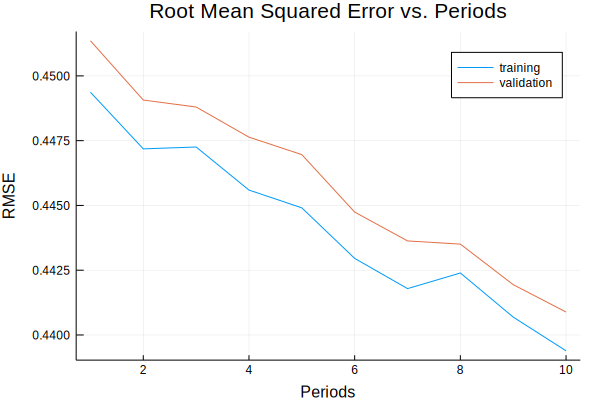

In [10]:
plot(p1)

## Task 1: Can We Calculate LogLoss for These Predictions?

**Examine the predictions and decide whether or not we can use them to calculate LogLoss.**

A linear regression model uses the L2 loss, which doesn't do a great job at penalizing misclassifications when the output is interpreted as a probability.  For example, there should be a huge difference whether a negative example is classified as positive with a probability of 0.9 vs 0.9999, but L2 loss doesn't strongly differentiate these cases.

In contrast, `LogLoss` penalizes these "confidence errors" much more heavily.  Remember, `LogLoss` is defined as:

$$Log Loss = \sum_{(x,y)\in D} -y \cdot log(y_{pred}) - (1 - y) \cdot log(1 - y_{pred})$$


But first, we'll need to obtain the prediction values. We could use `LinearRegressor.predict` to obtain these.

Given the predictions and that targets, can we calculate `LogLoss`?

### Solution

Click below to display the solution.

In [23]:
log.(validation_predictions+eps)

5000×1 Array{Float64,2}:
 -11.5129    
 -11.5129    
 -11.5129    
 -11.5129    
 -11.5129    
 -11.5129    
 -11.5129    
 -11.5129    
 -11.5129    
 -11.5129    
 -11.5129    
 -11.5129    
 -11.5129    
   ⋮         
   9.99995e-6
 -11.5129    
 -11.5129    
 -11.5129    
 -11.5129    
 -11.5129    
 -11.5129    
 -11.5129    
 -11.5129    
 -11.5129    
 -11.5129    
 -11.5129    

In [29]:
validation_predictions = (construct_feature_columns(validation_examples)*weight .+ bias) .> 0.5 
convert.(Float64, validation_predictions)

eps=1E-8
validation_log_loss=-mean(log.(validation_predictions.+eps).*construct_feature_columns(validation_targets) + log.(1.-validation_predictions.+eps).*(1.-construct_feature_columns(validation_targets))) 

4.642011539995994

## Task 2: Train a Logistic Regression Model and Calculate LogLoss on the Validation Set

To use logistic regression, we construct a model with a log loss function below.


In [30]:
function train_linear_classifier_model(learning_rate,
                     steps, 
                     batch_size, 
                     training_examples, 
                     training_targets, 
                     validation_examples, 
                     validation_targets)
  """Trains a linear classifier model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples:
    training_targets: 
    validation_examples: 
    validation_targets:
  Returns:
    weight: The weights of the model.
    bias: Bias of the model.
    validation_probabilities: Probabilities for the validation data.
    p1: Graph containing the loss function values for the different iterations.
  """
  
  periods = 10
  steps_per_period = steps / periods

  # Create feature columns.
  feature_columns = placeholder(Float32)
  target_columns = placeholder(Float32)
  eps=1E-8
  
  # Create a linear classifier object.
  # Configure the linear regression model with our feature columns and optimizer. 
  m=Variable(zeros(length(training_examples),1).+0.0)
  b=Variable(0.0)

  ytemp=nn.sigmoid(feature_columns*m + b)
  y= clip_by_value(ytemp, 0.0, 1.0)
  loss = -reduce_mean(log(y+eps).*target_columns + log(1-y+eps).*(1-target_columns)) 

  features_batches, targets_batches = create_batches(training_examples, training_targets, steps, batch_size)
    
  # Adam optimizer with gradient clipping
  my_optimizer=(train.AdamOptimizer(learning_rate))
  gvs = train.compute_gradients(my_optimizer, loss)
  capped_gvs = [(clip_by_norm(grad, 5.0), var) for (grad, var) in gvs]
  my_optimizer = train.apply_gradients(my_optimizer,capped_gvs) 
  run(sess, global_variables_initializer()) #this needs to be run after constructing the optimizer!
    
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  println("Training model...")
  println("LogLoss (on training data):")
  training_log_losses = []
  validation_log_losses=[]
  for period in 1:periods
    # Train the model, starting from the prior state.
   for i=1:steps_per_period
    features, labels = my_input_fn(features_batches, targets_batches, convert(Int,(period-1)*steps_per_period+i), batch_size)
    run(sess, my_optimizer, Dict(feature_columns=>construct_feature_columns(features), target_columns=>construct_feature_columns(labels)))
   end
    # Take a break and compute predictions.
    training_probabilities = run(sess, y, Dict(feature_columns=> construct_feature_columns(training_examples)));    
    validation_probabilities = run(sess, y, Dict(feature_columns=> construct_feature_columns(validation_examples)));  
        
    # Compute loss.
     training_log_loss=run(sess,loss,Dict(feature_columns=> construct_feature_columns(training_examples), target_columns=>construct_feature_columns(training_targets)))
     validation_log_loss =run(sess,loss,Dict(feature_columns=> construct_feature_columns(validation_examples), target_columns=>construct_feature_columns(validation_targets)))
        
    # Occasionally print the current loss.
    println("  period ", period, ": ", training_log_loss)
    weight = run(sess,m)
    bias = run(sess,b)
        
    loss_val=run(sess,loss,Dict(feature_columns=> construct_feature_columns(training_examples), target_columns=>construct_feature_columns(training_targets)))
        
    # Add the loss metrics from this period to our list.
    push!(training_log_losses, training_log_loss)
    push!(validation_log_losses, validation_log_loss)
 end

  weight = run(sess,m)
  bias = run(sess,b)
  
  println("Model training finished.")

  # Output a graph of loss metrics over periods.
  p1=plot(training_log_losses, label="training", title="LogLoss vs. Periods", ylabel="LogLoss", xlabel="Periods")
  p1=plot!(validation_log_losses, label="validation")

  println("Final LogLoss (on training data): ", training_log_losses[end])
    
  # calculate additional ouputs
  validation_probabilities = run(sess, y, Dict(feature_columns=> construct_feature_columns(validation_examples)));    
    
  return weight, bias, validation_probabilities, p1 #, calibration_data   
end

train_linear_classifier_model (generic function with 1 method)

In [31]:
weight, bias, validation_probabilities,  p1 = train_linear_classifier_model(
    0.000005, #learning rate
    500, #steps
    20, #batch_size
    training_examples,
    training_targets,
    validation_examples,
    validation_targets)

Training model...
LogLoss (on training data):
  period 1: 0.6065886629299466
  period 2: 0.5988623965647017
  period 3: 0.5847543768733174
  period 4: 0.5766758629941485
  period 5: 0.5725946767906234
  period 6: 0.5622120710406342
  period 7: 0.5548644186964
  period 8: 0.5597769998066245
  period 9: 0.5439031104829061
  period 10: 0.5389006469973862
Model training finished.


([-0.0014546; 0.0014167; … ; 0.000955708; -0.000716255], -0.0010572637687903841, [0.293846; 0.343819; … ; 0.395276; 0.363905], Plot{Plots.GRBackend() n=2})

Final LogLoss (on training data): 0.5389006469973862


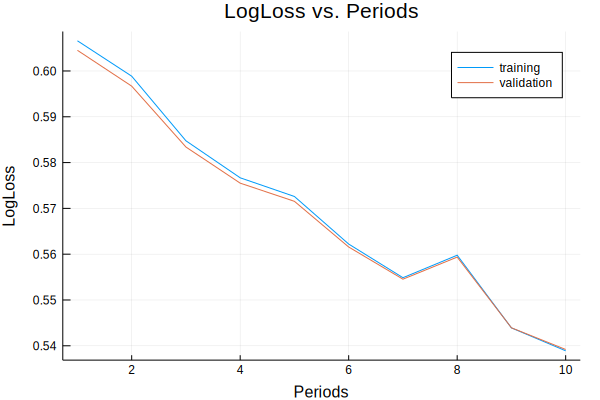

In [32]:
plot(p1)

## Task 3: Calculate Accuracy and plot a ROC Curve for the Validation Set

A few of the metrics useful for classification are the model [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification), the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and the area under the ROC curve (AUC). We'll examine these metrics.

First, we need to convert probabilities back to 0/1 labels:

In [33]:
# Function for converting probabilities to 0/1 decision
function castto01(probabilities)
    out=copy(probabilities)
    for i=1:length(probabilities)
        if(probabilities[i]<0.5)
            out[i]=0
        else
            out[i]=1
        end
    end
    return out
end    

castto01 (generic function with 1 method)

We use `sklearn`'s metric functions to calculate the ROC curve.

In [34]:
@pyimport sklearn.metrics as sklm
evaluation_metrics=DataFrame()
false_positive_rate, true_positive_rate, thresholds = sklm.roc_curve(
    vec(construct_feature_columns(validation_targets)), vec(validation_probabilities))
evaluation_metrics[:auc]=sklm.roc_auc_score(construct_feature_columns(validation_targets), vec(validation_probabilities))
validation_predictions=castto01(validation_probabilities);
evaluation_metrics[:accuracy]=sum(1-(construct_feature_columns(validation_targets)-validation_predictions))/length(validation_predictions);
p2=plot(false_positive_rate, true_positive_rate, label="our model")
p2=plot!([0, 1], [0, 1], label="random classifier");

In [35]:
#evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)
println("AUC on the validation set: ",  evaluation_metrics[:auc])
println("Accuracy on the validation set: ", evaluation_metrics[:accuracy])

AUC on the validation set: [0.710477]
Accuracy on the validation set: [0.757]


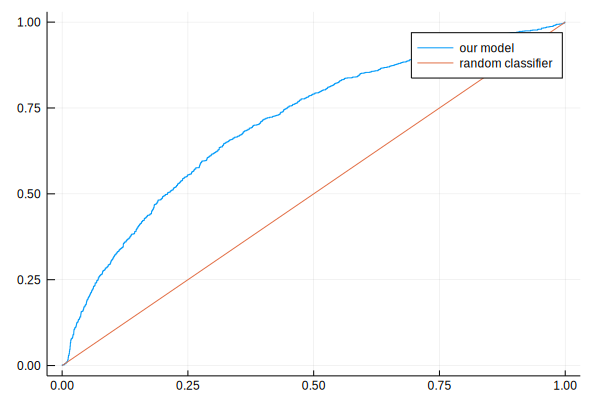

In [36]:
plot(p2)

**See if you can tune the learning settings of the model trained at Task 2 to improve AUC.**

Often, certain metrics improve at the detriment of others, and you'll need to find the settings that achieve a good compromise.

**Verify if all metrics improve at the same time.**

One possible solution that works is to just train for longer, as long as we don't overfit. 

We can do this by increasing the number the steps, the batch size, or both.

All metrics improve at the same time, so our loss metric is a good proxy
for both AUC and accuracy.

Notice how it takes many, many more iterations just to squeeze a few more 
units of AUC. This commonly happens. But often even this small gain is worth 
the costs.

In [37]:
# TUNE THE SETTINGS BELOW TO IMPROVE AUC
weight, bias, validation_probabilities,  p1 = train_linear_classifier_model(
    0.000003, #learning rate
    20000, #steps
    500, #batch_size
    training_examples,
    training_targets,
    validation_examples,
    validation_targets)

evaluation_metrics=DataFrame()
validation_predictions=castto01(validation_probabilities);
evaluation_metrics[:accuracy]=sum(1-(construct_feature_columns(validation_targets)-validation_predictions))/length(validation_predictions);
evaluation_metrics[:auc]=sklm.roc_auc_score(construct_feature_columns(validation_targets), vec(validation_probabilities))
false_positive_rate, true_positive_rate, thresholds = sklm.roc_curve(
    vec(construct_feature_columns(validation_targets)), vec(validation_probabilities))
p2=plot(false_positive_rate, true_positive_rate, label="our model")
p2=plot!([0, 1], [0, 1], label="random classifier");

println("AUC on the validation set: ",  evaluation_metrics[:auc])
println("Accuracy on the validation set: ", evaluation_metrics[:accuracy])

Training model...
LogLoss (on training data):
  period 1: 0.48976944885389595
  period 2: 0.4742104045827638
  period 3: 0.4653901491298947
  period 4: 0.4597924447356923
  period 5: 0.455838893437722
  period 6: 0.45292006873156576
  period 7: 0.45062018104487256
  period 8: 0.44866425755973594
  period 9: 0.44703674326104387
  period 10: 0.44564716744539973
Model training finished.
Final LogLoss (on training data): 0.44564716744539973
AUC on the validation set: [0.82479]
Accuracy on the validation set: [0.8448]


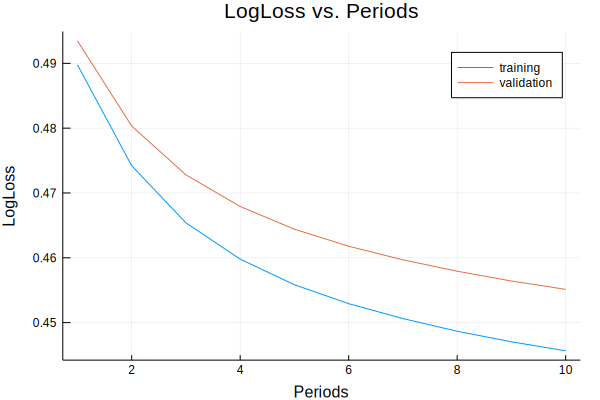

In [38]:
plot(p1)

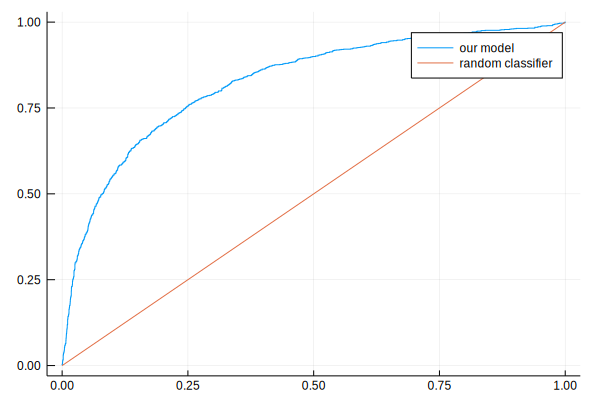

In [39]:
plot(p2)

In [ ]:
#EOF